In [93]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
import cx_Oracle
import matplotlib.pyplot as plt
import time 
import os
import pickle

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Finbox SDK removal impact")
seed = 5

# Read Data

In [94]:
df = pd.read_csv(os.getcwd()+r"\Data Files\export.csv")

In [95]:
df["RESULT"] = np.where(df["POS_AUG20_SDK_TEXT"]==-3.18,"NOT FOUND","FOUND")

df = df[df["DECISION_OVERALL"]=="Approved"]
df = df[df["RESULT"]=="FOUND"]


# Define Key Variables

In [96]:
time_decision_date = 'TIME_CREATION_DATE'
source = 'SDK'
target_variable = "RISK_FPD30"
fnf_flag = 'RESULT'
score = 'NEW_GM'
risk_score = 'POS_MAR20_GM_EXI'

# Data Cleaning

In [97]:
#One Hot Encoding of fnf_flag
dummy = pd.get_dummies(df[fnf_flag])
dummy.columns = [y+"_"+fnf_flag for y in dummy.columns]
df = pd.concat([df, dummy], axis=1)

In [98]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,POS_MAR20_GM_EXI,POS_TYPE,RISK_AGRF30,RISK_FPD30,RISK_AGRF150,RISK_FSTQPD60,DECISION_OVERALL,FLAG_1PCT_PHANTOM,POS_AUG20_SDK_NUM,POS_AUG20_SDK_TEXT,NEW_GM,ASIS_GM_NTILE,NEW_GM_NTILE,DECISION_ASIS,DECISION_NEW,RESULT,FOUND_RESULT
0,324146689,25-10-20,0.001101,AP,1,0,1,0,Approved,0,-2.004105,-3.320254,0.001198,1,1,Approved,Approved,FOUND,1
1,323378682,17-10-20,0.001177,AP,1,0,1,0,Approved,0,-1.945923,-3.223862,0.001209,1,1,Approved,Approved,FOUND,1
2,326036164,14-11-20,0.001311,AP,1,0,1,0,Approved,0,-2.056989,-3.407867,0.001505,1,1,Approved,Approved,FOUND,1
3,331732099,10-01-21,0.000904,AP,1,0,1,0,Approved,0,-2.452735,-4.063510,0.001540,1,1,Approved,Approved,FOUND,1
7,324691617,01-11-20,0.001698,AP,1,0,1,0,Approved,0,-1.945923,-3.223862,0.001744,1,1,Approved,Approved,FOUND,1


In [99]:
df[time_decision_date] = pd.to_datetime(df[time_decision_date],format = '%d-%m-%y')
df["MONTH_STR"] = df[time_decision_date].dt.strftime("%y-%m")

<AxesSubplot:>

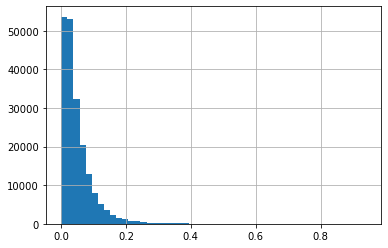

In [100]:
df[df["RESULT"]=="FOUND"]["POS_MAR20_GM_EXI"].hist(bins = 50)

<AxesSubplot:>

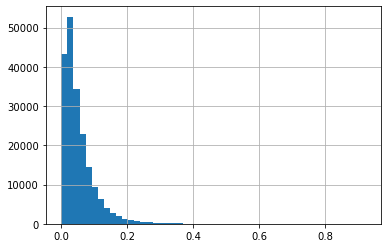

In [101]:
df[df["RESULT"]=="FOUND"]["NEW_GM"].hist(bins = 50)

In [102]:
print("Exi GM Gini: ", 2*roc_auc_score(df["RISK_FPD30"],df[risk_score])-1)
print("New GM Gini: ", 2*roc_auc_score(df["RISK_FPD30"],df[score])-1)

Exi GM Gini:  0.41311065865059127
New GM Gini:  0.3974169584090528


# MOM Plot of delinquency

In [103]:
df_agg=df[["MONTH_STR",target_variable]].groupby(["MONTH_STR"]).agg(["count","sum"])
df_agg.columns = ['_'.join(x) for x in df_agg.columns]
df_agg["BAD_RATE"] = df_agg["RISK_FPD30_sum"]/df_agg["RISK_FPD30_count"]

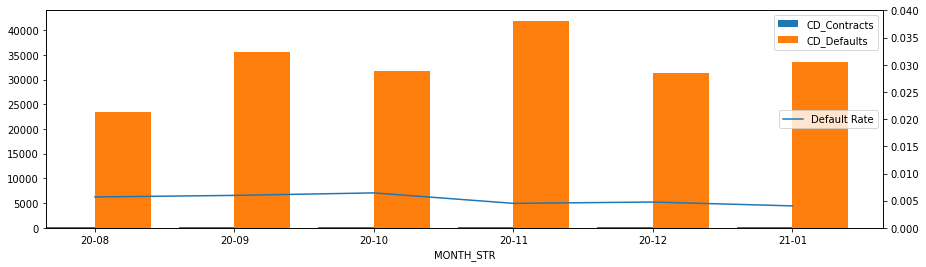

In [104]:
df_agg[['RISK_FPD30_sum','RISK_FPD30_count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_agg['BAD_RATE'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_agg['RISK_FPD30_sum'])-0.35])
ax.set_xticklabels(df_agg.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.04)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")
plt.show()

# Model Evaluation FPD30

### Gini Chart

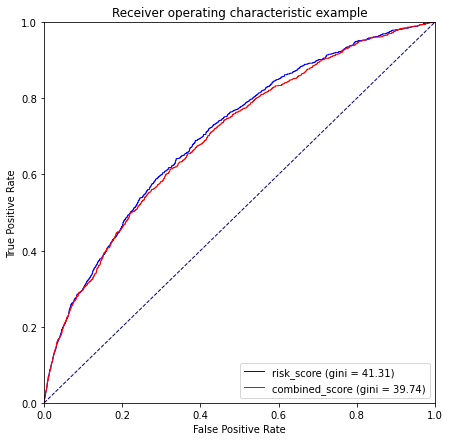

In [105]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1


fpr, tpr, thresholds = roc_curve(df[target_variable],df[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='risk_score (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df[target_variable],df[score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='combined_score (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [106]:
gini_dic = {}
for x in df["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if risk_score not in gini_dic: 
            gini_dic[risk_score] = []
        if score not in gini_dic: 
            gini_dic[score] = []
        
        gini_dic[risk_score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic[score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][score])-1)*100)
        gini_dic["MONTH_STR"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


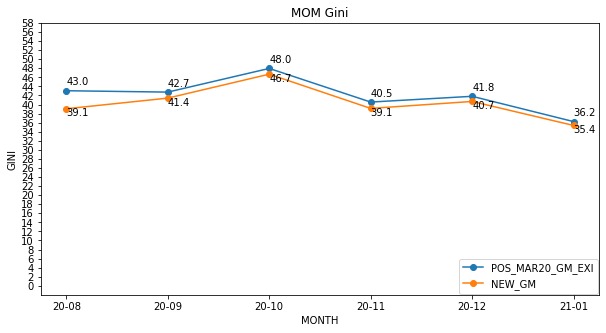

In [107]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
ax1.plot(gini_df["MONTH_STR"],gini_df[score], marker='o', scaley = False, label = score)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df[risk_score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]+1.2))
for i, txt in enumerate(gini_df[score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[score][i]-1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,60,2))
ax1.set_title("MOM Gini")
plt.show()


## Lifts and Gains Chart

In [108]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [109]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped[[prob,"bucket"]].agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped[[prob,"bucket"]].agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped[[target,"bucket"]].agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped[[target,"bucket"]].agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped[['target0',"bucket"]].agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [110]:
#cum%_bads is gain_score
risk_score_lift = lift_and_gain_df(data=df,target=target_variable, prob=risk_score)
score_lift = lift_and_gain_df(data=df,target=target_variable, prob=score)

### Cumulative Lift Chart 

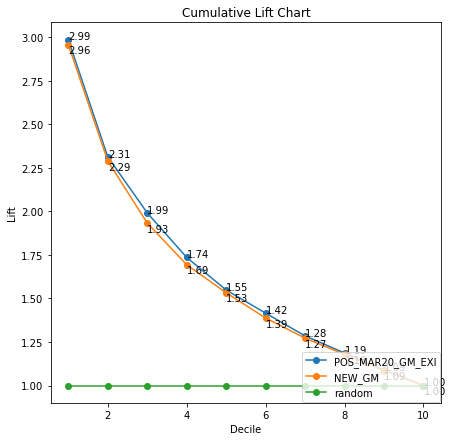

In [113]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)



ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = risk_score, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(score_lift.index,score_lift["cum_lift"], label = score, marker='o')
for i, txt in enumerate(score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (score_lift.index[i], score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    


# Model Evaluation FSTQPD60

In [114]:
target_variable = "RISK_FSTQPD60"

### Gini Chart

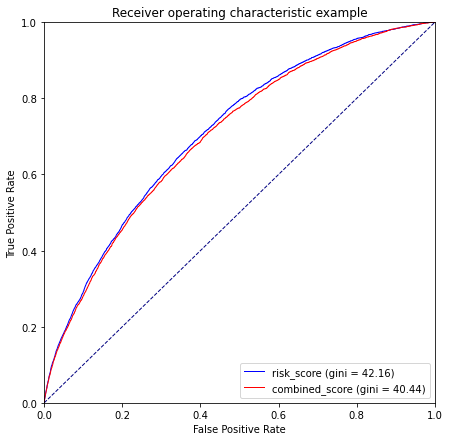

In [115]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1


fpr, tpr, thresholds = roc_curve(df[target_variable],df[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='risk_score (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df[target_variable],df[score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='combined_score (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [116]:
gini_dic = {}
for x in df["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if risk_score not in gini_dic: 
            gini_dic[risk_score] = []
        if score not in gini_dic: 
            gini_dic[score] = []
        
        gini_dic[risk_score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic[score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][score])-1)*100)
        gini_dic["MONTH_STR"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


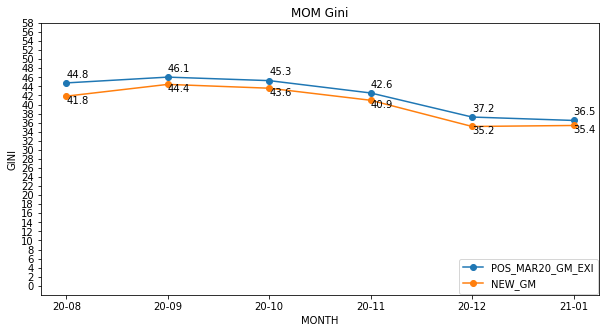

In [117]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
ax1.plot(gini_df["MONTH_STR"],gini_df[score], marker='o', scaley = False, label = score)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df[risk_score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]+1.2))
for i, txt in enumerate(gini_df[score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[score][i]-1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,60,2))
ax1.set_title("MOM Gini")
plt.show()


## Lifts and Gains Chart

In [118]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [119]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped[[prob,"bucket"]].agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped[[prob,"bucket"]].agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped[[target,"bucket"]].agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped[[target,"bucket"]].agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped[['target0',"bucket"]].agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [120]:
#cum%_bads is gain_score
risk_score_lift = lift_and_gain_df(data=df,target=target_variable, prob=risk_score)
score_lift = lift_and_gain_df(data=df,target=target_variable, prob=score)

### Cumulative Lift Chart 

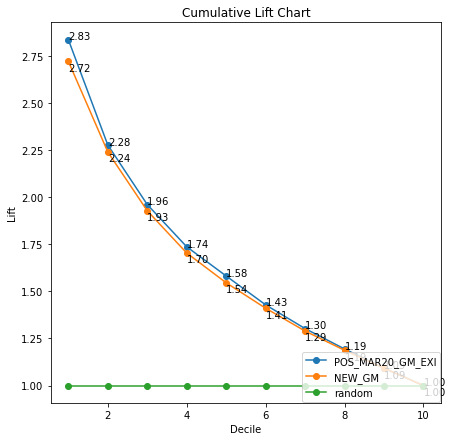

In [121]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)



ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = risk_score, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(score_lift.index,score_lift["cum_lift"], label = score, marker='o')
for i, txt in enumerate(score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (score_lift.index[i], score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    
